In [1]:
import pandas as pd
import numpy as np


In [2]:
import sys
sys.path.append('../')

import constants as params

In [3]:
bucket = "humana-data"
prefix = 'rawdata/original_pq_files'
prefix_data = "intermediate/condition/data"
prefix_metadata = "intermediate/condition/models/metadata"
prefix_model = "intermediate/condition/models"

In [4]:
prefix_data_raw = 'C:\\Users\\mohad\\OneDrive - University of South Florida\\Studies\\USF\\Humana-Github\\data\\rawdata\\original_pq_files\\'
prefix_data_inter = 'C:\\Users\\mohad\\OneDrive - University of South Florida\\Studies\\USF\\Humana-Github\\data\\intermediate\\'

pharmacy_file = "Pharm.pq"
dependent_file = 'dependent.pq'

In [5]:
def create_columns_types(df):
    data_types = {}
    data_types['category'] = [x for x in df.columns if '_ind'  in x]
    data_types['numeric'] = [x for x in df.columns if '_ind' not in x]
    return data_types

### RX_other features

In [6]:
def rx_others(df, params):
    metadata = {}
    metadata['pharmacy'] = {}
    
    rx_others_df = df[params.rx_other_attributes]
    
    metadata['pharmacy']['category'] = list(rx_others_df.columns[rx_others_df.columns.str.contains("_ind")])
    metadata['pharmacy']['numeric'] = list(rx_others_df.columns[rx_others_df.columns.str.contains("_pmpm")])
    return rx_others_df, metadata
    

### RX_gpi2

In [7]:
def gpi2_sum_features(df, params):
    for category in params.drug_categories.keys():
        df[category+'_sum'] = df[[x for x in data_types['category'] for y in params.drug_categories[category] if y in x]].sum(axis=1)
    return df

In [8]:
def gpi2_percent(df, params):

    drug_freq_dict = {k+'_freq':len(v) for k,v in params.drug_categories.items()}

    for category in params.drug_categories.keys():
        sum_column = df.columns[df.columns.str.contains(category+'_sum')]
        freq = drug_freq_dict[category+'_freq']
        df[category + "_perc"] = df[sum_column]/freq
    return df


In [9]:
def gpi2_features(df, data_types, metadata):
    # categorical features engineering
    df[data_types['category']] = np.where(df[data_types['category']] != 0, 1,0)
    df = gpi2_sum_features(df = df, params=params)
    df = gpi2_percent(df, params)
    
    pd_data_types_cat = pd.Index(data_types['category'])
    categorical_cols = pd_data_types_cat[(pd_data_types_cat.str.contains('rx_gpi2_')) & 
                                (pd_data_types_cat.str.endswith("_ind"))].tolist()
    
    pd_data_types_num = pd.Index(data_types['numeric'])
    numeric_cols = pd_data_types_num[(pd_data_types_num.str.contains('rx_gpi2_')) & 
                                (pd_data_types_num.str.endswith("_pmpm_ct"))].tolist()
    
    numeric_cols.extend(df.columns[df.columns.str.contains("_sum")].tolist())
    numeric_cols.extend(df.columns[df.columns.str.contains("_perc")].tolist())
    
    gpi2_df = df[categorical_cols + numeric_cols]
    metadata['pharmacy']['category'].extend(categorical_cols)
    metadata['pharmacy']['numeric'].extend(numeric_cols)
    
    return gpi2_df, metadata
    

In [10]:
df = pd.read_parquet(prefix_data_raw + pharmacy_file)
df = df.set_index('person_id_syn')
df.columns = df.columns.str.lower()

dep_df = pd.read_parquet(prefix_data_raw + dependent_file)
dep_df = dep_df.set_index('person_id_syn')
dep_df.columns = dep_df.columns.str.lower()


data_types = create_columns_types(df)
rx_others_df, metadata = rx_others(df=df, params=params)
gpi_2_df, metadata = gpi2_features(df=df, data_types=data_types, metadata=metadata)

In [11]:

df_fe = rx_others_df.merge(gpi_2_df, how ='left', left_index=True, right_index= True)
df_fe = dep_df.merge(df_fe, how ='left', left_index=True, right_index=True)

In [12]:
df_fe

,transportation_issues,rx_bh_ind,rx_bh_pmpm_ct,rx_branded_ind,rx_branded_pmpm_ct,rx_generic_ind,rx_generic_pmpm_ct,rx_mail_pmpm_ct,rx_mail_ind,rx_maint_ind,...,antibiotics_sum,immuno_sum,hormonal_sum,kidney_sum,resp_sum,antibiotics_perc,immuno_perc,hormonal_perc,kidney_perc,resp_perc
person_id_syn,,,,,,,,,,,,,,,,,,,,,
0002MOb79ST17bLYAe46eIc2,0,0,0.000000,0,0.000000,1,0.100552,0.000000,0,0,...,1,0,0,0,1,0.071429,0.0,0.000000,0.0,0.017857
0004cMOS6bTLf34Y7AIca8f3,0,1,0.467750,1,0.026849,1,2.245541,0.627787,1,1,...,0,1,0,2,5,0.000000,0.2,0.000000,0.2,0.089286
000536M9O3ST98LaYaeA29Ia,1,1,0.083333,1,1.500000,1,2.500000,3.333333,1,1,...,0,0,2,2,6,0.000000,0.0,0.222222,0.2,0.107143
0009bMO9SfTLYe77A51I4ac3,0,1,0.083333,0,0.000000,1,2.666667,2.500000,1,1,...,0,0,0,4,4,0.000000,0.0,0.000000,0.4,0.071429
000M7OeS66bTL8bY89Aa16Ie,0,0,0.000000,1,0.083333,1,3.666667,0.433333,1,1,...,0,0,1,4,3,0.000000,0.0,0.111111,0.4,0.053571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe33MOS25dTf027LaY7A5I3,0,0,0.000000,1,0.916667,1,3.000000,2.166667,1,1,...,2,0,2,2,4,0.142857,0.0,0.222222,0.2,0.071429
fff1M4O1cfST49LY464A2Ieb,0,0,0.000000,1,0.316024,1,4.236477,2.571778,1,1,...,1,2,0,4,3,0.071429,0.4,0.000000,0.4,0.053571
fff5MO7e401STLYcAd8e581I,0,0,0.000000,0,0.000000,1,0.333333,1.666667,1,1,...,0,0,0,3,4,0.000000,0.0,0.000000,0.3,0.071429


### Train the model

In [13]:
import pandas as pd

import boto3
import numpy as np
import io
# import awswrangler as wr
# import sagemaker
# from sagemaker import get_execution_role
# from sagemaker.session import s3_input, Session
import pickle
# from sagemaker.amazon.amazon_estimator import get_image_uri

from sklearn.preprocessing import OneHotEncoder
# Save the encoded categorical model
import tempfile
import joblib

import warnings
warnings.filterwarnings('ignore')

In [14]:
train_df = df_fe.sample(frac=0.7, random_state=543)
valid_df = df_fe[~(df_fe.index.isin(train_df.index))]

In [25]:
categorical_cols = metadata['pharmacy']['category']
numerical_cols = metadata['pharmacy']['numeric']

In [23]:
# one hot encoding
enc = OneHotEncoder(sparse=False, handle_unknown="ignore" )
one_hot_encode_cols = [x for x in categorical_cols if x != params.dependent_variable]
train_df_encoded = pd.DataFrame(enc.fit_transform(train_df[one_hot_encode_cols]), index=train_df.index)
train_df_encoded.columns = enc.get_feature_names_out()

train_model_df = pd.concat([train_df.drop(one_hot_encode_cols, axis=1), train_df_encoded], axis=1, ignore_index=False)

In [24]:
valid_df_encoded = pd.DataFrame(enc.transform(np.asarray(valid_df[one_hot_encode_cols], dtype=object)),
                                index=valid_df.index)
valid_df_encoded.columns = enc.get_feature_names_out()
valid_model_df = pd.concat([valid_df.drop(one_hot_encode_cols, axis=1), valid_df_encoded], axis=1, ignore_index=False)

In [26]:
X_train = train_model_df.sample(10000).drop(columns= ['transportation_issues'])
y_train = train_model_df[train_model_df.index.isin(X_train.index)]['transportation_issues'].astype(int)

X_valid = valid_model_df.drop(columns= ['transportation_issues'])
y_valid = valid_model_df[valid_model_df.index.isin(X_valid.index)]['transportation_issues'].astype(int)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred_valid=logistic_regression.predict(X_valid)
y_pred_train=logistic_regression.predict(X_train)

print('Accuracy: ',metrics.accuracy_score(y_valid, y_pred_valid))
print('Accuracy: ',metrics.accuracy_score(y_train, y_pred_train))

Accuracy:  0.8531046377922575
Accuracy:  0.8492


In [28]:
# Hyperparameter tuning grid
params = {'min_child_weight': [5],
        'gamma': [1.5],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'max_depth': [4]}

from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
# Initialize XGBoost model, use growth tree algorithm similar to lightgbm
bst = XGBClassifier(n_jobs=-1,grow_policy='lossguide',tree_method ='hist',n_estimators=150)
# Gridsearch on parameter grid, use AUC to determine the best model
cv = GridSearchCV(bst, params)
# Fit model on the training data, track logloss on training and validing set
cv.fit(X_train, y_train,eval_metric='logloss',eval_set=[(X_train,y_train),(X_valid,y_valid)],verbose=False)



GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, grow_policy='lossguide',
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
             

0.8483614411651974
0.8745


<Figure size 1440x1080 with 0 Axes>

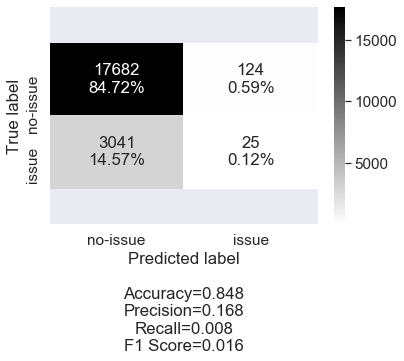

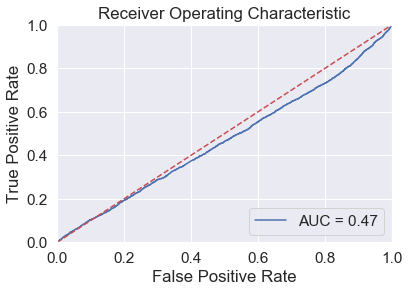

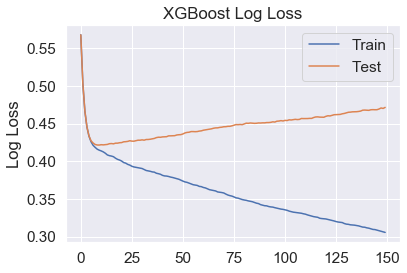

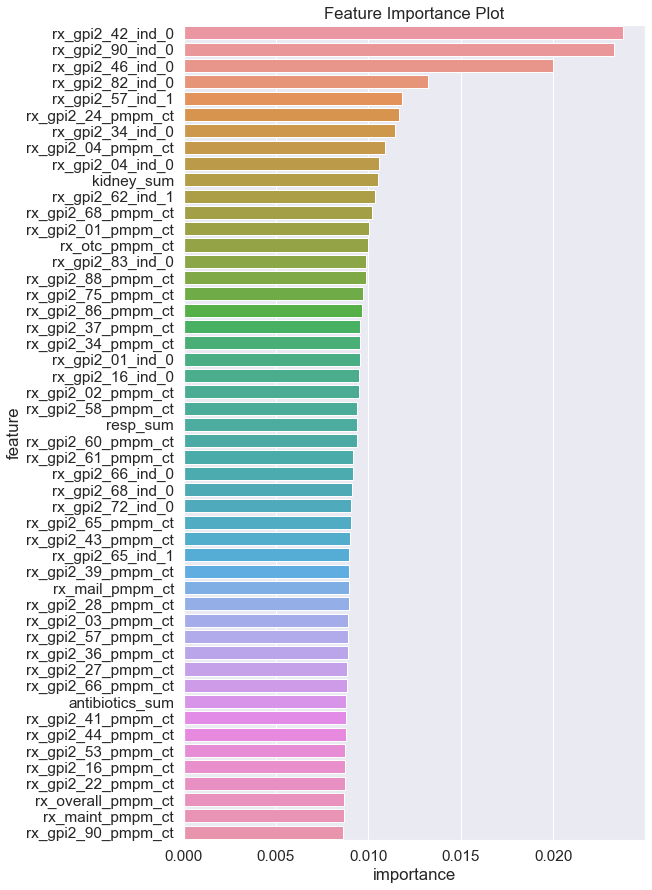

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

import cf_matrix
from cf_matrix import make_confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score

y_xg_pred_valid = cv.best_estimator_.predict(X_valid)
y_xg_pred_train = cv.best_estimator_.predict(X_train)

print(metrics.accuracy_score(y_valid, y_xg_pred_valid))
print(metrics.accuracy_score(y_train, y_xg_pred_train))


cm = confusion_matrix(y_valid, y_xg_pred_valid)
plt.figure(figsize=(20,15))
sns.set(font_scale=1.4) # for label size
make_confusion_matrix(cm, group_names=['no- issue','issue'],categories=['no-issue','issue'], cmap='binary')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) 
plt.show()

import joblib

# Print out the best parameters
cv.best_params_

#save model
joblib.dump(cv.best_estimator_, 'xgb.model')


#load saved model
xgb = joblib.load('xgb.model')


import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = xgb.predict_proba(X_valid)
preds = probs[:,1]
# preds = [1]*17119
fpr, tpr, threshold = metrics.roc_curve(y_valid, preds)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss');

# Feature importance plot
feature_importance = pd.DataFrame({'feature':xgb.get_booster().feature_names, 'importance':xgb.feature_importances_}).sort_values('importance',ascending=False).reset_index().drop(columns='index')
fig, ax = plt.subplots()
fig.set_size_inches(8.27,15)
plt.title('Feature Importance Plot')
sns.barplot(x='importance',y='feature',ax=ax,data=feature_importance[:50])


In [53]:
top_features = list(feature_importance[feature_importance.importance>0.009].feature)
# top_features

In [54]:
cat_top_features = (pd.Series([x for x in top_features if '_ind' in x]).str.split('_ind_').str[0] + "_ind").tolist()
num_top_features = [x for x in top_features if '_ind' not in x]

In [61]:
pharm_final_features = cat_top_features + num_top_features
pharm_final_features

['rx_gpi2_42_ind',
 'rx_gpi2_90_ind',
 'rx_gpi2_46_ind',
 'rx_gpi2_82_ind',
 'rx_gpi2_57_ind',
 'rx_gpi2_34_ind',
 'rx_gpi2_04_ind',
 'rx_gpi2_62_ind',
 'rx_gpi2_83_ind',
 'rx_gpi2_01_ind',
 'rx_gpi2_16_ind',
 'rx_gpi2_66_ind',
 'rx_gpi2_68_ind',
 'rx_gpi2_72_ind',
 'rx_gpi2_24_pmpm_ct',
 'rx_gpi2_04_pmpm_ct',
 'kidney_sum',
 'rx_gpi2_68_pmpm_ct',
 'rx_gpi2_01_pmpm_ct',
 'rx_otc_pmpm_ct',
 'rx_gpi2_88_pmpm_ct',
 'rx_gpi2_75_pmpm_ct',
 'rx_gpi2_86_pmpm_ct',
 'rx_gpi2_37_pmpm_ct',
 'rx_gpi2_34_pmpm_ct',
 'rx_gpi2_02_pmpm_ct',
 'rx_gpi2_58_pmpm_ct',
 'resp_sum',
 'rx_gpi2_60_pmpm_ct',
 'rx_gpi2_61_pmpm_ct',
 'rx_gpi2_65_pmpm_ct',
 'rx_gpi2_43_pmpm_ct']